In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
import pickle
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib as plt

### Lasso Regression Model

In [2]:
df_data = pd.read_csv('../data/df18to21_cleanedH.csv')

In [3]:
X = df_data.drop(columns=['sentence_length','guideline_range','guideline_var_pct','region','white'])
y = df_data['sentence_length']

In [4]:
numeric = ['age','count_convictons']
categorical = ['year_sentenced','dependents','race','disposition','citizen',
               'state','criminal_hist', 'drug_type','weapon','gender','crime_type',
               'case_type','presentence_stat','sentence_type','college','imprisoned']


In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [6]:
ctx = ColumnTransformer(
    [
    ('ss',StandardScaler(),numeric),
    ('ohe',OneHotEncoder(handle_unknown='ignore'),\
     categorical)
    ],
     verbose_feature_names_out=False,
     remainder = 'passthrough'
)

In [7]:
lasso_pipe = Pipeline(
    [
    ('ct',ctx),
    ('lasso',Lasso(alpha=.001,random_state=42,max_iter=10000))
    ]
)


In [8]:
lasso_pipe.fit(X_train,y_train)
lasso_pipe.score(X_train,y_train)

0.5253975466497385

In [9]:
lasso_pipe.score(X_test,y_test)

0.5142388561217157

In [10]:
cross_val_score(lasso_pipe,X,y,cv=3)

array([0.50506421, 0.52563896, 0.51854375])

The model used to explore the relationships between features and federal sentence length is a Lasso regression that uses an alpha of .001. The data is scaled and one-hot encoded. The data analyzed also caps sentence length at 70 years (840 months), thus sentence lengths of longer than 70 years, or life sentences, were imputed as 70 years. Given the consecutive sentences imposed by federal courts, in which the offender is ordered to serve sentences back-to-back, it becomes very hard to successfully model the data unless a modification of this type is made. The r-squared value for this same model without modifying sentence length was ~.10. The paper we studied (link provided below) from the U.S. Sentencing Commission capped the sentence length at ~39 years for its analysis of similar data in 2012. 

This model was selected because it provided the best r-squared score, explaining 51.42% of the variance around the mean in the test set. While this is not an exceptionally strong model in terms of this metric, given our understanding of the complex process of federal sentencing, and the extensive array of guidlines, we felt that this model was suitably strong to provide us with insight into how the features we are studying impact sentence length. Additional iterations with interaction variables did not provide increased model performance.

A review of the U.S. Sentencing Commission studies on similar data from earlier perdiods confirmed for the team that a model with an r-squared score of .5142 is acceptable to move forward with for analysis. It should be noted that the study was a multivariate analysis, and used a different set of features, some of which we felt were too closely related to sentence length (number of armed career criminal points assigned to a defendant, for instance). 

https://www.ussc.gov/sites/default/files/pdf/research-and-publications/research-publications/2010/20100311_Multivariate_Regression_Analysis_Report.pdf

https://www.ussc.gov/sites/default/files/pdf/research-and-publications/research-publications/2017/20171114_Demographics.pdf


In [11]:
preds = lasso_pipe.predict(X_test)
resids = y_test - preds

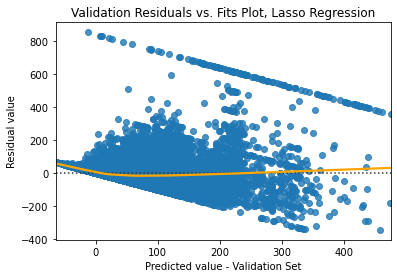

In [12]:
sns.residplot(x = preds,
              y = resids,
              lowess = True,
              line_kws = {'color':'orange'})\
    .set(title = 'Validation Residuals vs. Fits Plot, Lasso Regression',
        xlabel = 'Predicted value - Validation Set',
        ylabel = 'Residual value');

## Coefficient Analysis

The below coefficients reflect the association the respective feature has with sentence length, with all other variables held equal. these coefficients are derived from the lasso model fit and scored above.

In [13]:
lc_dff = pd.DataFrame()
lc_dff['feature'] = [i for i in lasso_pipe.named_steps['ct'].get_feature_names_out()]
lc_dff['coeffs'] = [i for i in lasso_pipe.named_steps['lasso'].coef_]

In [14]:
lc_dff.sort_values(by='coeffs',ascending=False).head(5)

,feature,coeffs
107,crime_type_22,234.308357
112,crime_type_27,171.926253
104,crime_type_19,106.106380
18,disposition_5,86.771263
92,crime_type_7,70.678223


The coefficients most strongly associated with longer sentences are the primary offense type as murder (the highest coefficient by a decent margin), sex abuse, child pornography or kidnapping, and a special case in which an offender both sits for a trial and also pleads guilty.

In [15]:
lc_dff.sort_values(by='coeffs',ascending=False).tail(5)

,feature,coeffs
78,drug_type_4.0,-23.578929
110,crime_type_25,-27.480103
14,disposition_1,-28.086450
15,disposition_2,-28.983393
82,weapon_0,-39.980866


The coefficients most strongly associated with shorter sentences are those that indicate that an offender was not carrying a firearm during the crime, the defendant pled guilty or no contest, if the crime was a prison offense, or if the drug offense is related to marijuana.


### Crime Type Coefficients

In [16]:
crime_coeff = lc_dff[lc_dff['feature'].str.contains("crime")]
crime_coeff.sort_values(by='coeffs',ascending=False).head()

,feature,coeffs
107,crime_type_22,234.308357
112,crime_type_27,171.926253
104,crime_type_19,106.106380
92,crime_type_7,70.678223
105,crime_type_20,40.990743


As seen above, murder, sex abuse, child pornography and kidnapping are the model's coefficients that are most strongly associated with a long sentence. Manslaughter is the additional crime that is in the five crime types most associated with long sentences.

In [17]:
crime_coeff.sort_values(by='coeffs',ascending=False).tail()

,feature,coeffs
94,crime_type_9,-15.910101
109,crime_type_24,-16.821978
86,crime_type_1,-18.414356
102,crime_type_17,-21.665898
110,crime_type_25,-27.480103


The crime types most associated with shorter sentences are prison offenses, immigration, administration of justice (obstruction of justice, etc.), obscenity and drug possession.

### State Coefficients

In [18]:
state_coeff = lc_dff[lc_dff['feature'].str.contains("state")]
state_coeff['feature'] = [i.split('_')[1] for i in state_coeff['feature']]
state_coeff = state_coeff.rename(columns={'feature':'state'})


/var/folders/pr/wgwfmfsx53n97rhpm9z12wqh0000gn/T/ipykernel_11704/2435092372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_coeff['feature'] = [i.split('_')[1] for i in state_coeff['feature']]


In [19]:
state_coeff.sort_values(by='coeffs',ascending=False).head(10)

,state,coeffs
36,Iowa,20.260049
44,Minnesota,16.893141
30,Florida,14.901662
35,Indiana,13.660364
38,Kentucky,9.662730
67,Virginia,9.580896
61,South Carolina,9.365511
54,North Carolina,9.319177
43,Michigan,9.114604
48,Nebraska,7.772451


The states most associated with longer sentences are Iowa, Minnesota, Florida, Indiana and Kentucky. Relative to the crime type coefficients associated with longer sentences, these coefficients are fairly weak.

In [20]:
state_coeff.sort_values(by='coeffs',ascending=False).tail(10)

,state,coeffs
27,Connecticut,-7.695231
25,California,-8.418154
53,New York,-8.801427
29,District of Columbia,-8.815338
68,Washington,-9.912397
69,West Virginia,-10.726324
60,Rhode Island,-11.422657
47,Montana,-12.159093
65,Utah,-13.741828
66,Vermont,-21.811510


The states most associated with short sentences are: Vermont, Utah, Montana, Rhode Island and West Virginia.

### Race Coefficients

In [21]:
race_coeff = lc_dff[lc_dff['feature'].str.contains("race")]
race_coeff.sort_values(by='coeffs')

,feature,coeffs
11,race_3,-18.746610
8,race_0,-0.031928
9,race_1,-0.000000
13,race_7,0.000000
10,race_2,1.638227
12,race_4,3.423411


The notable coefficient related to race is that sentences for Native Americans and Alaskan Natives tend to be shorter, all alse equal. However, the median sentence legnth for Native Americans and Native Alaskans is 27 years, compared with 18 years for the offender population as a whole. While more serious crimes involving Native American and Alaskan Natives are heard at federal level, and lesser offenses tried at tribal level, the cause for this association with lower sentence lengths is unclear as of yet. 

### Gender Coefficients

In [22]:
gender_coeff = lc_dff[lc_dff['feature'].str.contains("gender")]
gender_coeff.sort_values(by='coeffs')

,feature,coeffs
85,gender_1.0,-0.000000
84,gender_0.0,11.776185


A male offender is more likely to have a longer sentence compared to a woman, with all other features held constant.

### Drug Coefficients

In [23]:
drug_coeff = lc_dff[lc_dff['feature'].str.contains("drug")]
drug_coeff.sort_values(by='coeffs')

,feature,coeffs
78,drug_type_4.0,-23.578929
74,drug_type_0.0,-21.610464
81,drug_type_77.0,-7.174072
76,drug_type_2.0,-4.363870
80,drug_type_7.0,0.001210
77,drug_type_3.0,1.589177
75,drug_type_1.0,4.991743
79,drug_type_6.0,26.183594


Cases involving marijuana and no drugs tend to involve short sentences. Cases involving methamphetamine are associated with longer sentences, of all the drug types studied.

### Education Coefficients

In [24]:
education_coeff = lc_dff[lc_dff['feature'].str.contains("college")]
education_coeff.sort_values(by='coeffs')

,feature,coeffs
128,college_1,-1.217616e-09
127,college_0,1.760533e+00


Education level, whether one has attended any college or not, has little effect on sentencing length.

### Criminal History Coefficients

In [25]:
crimhist_coeff = lc_dff[lc_dff['feature'].str.contains('criminal_hist')]
crimhist_coeff.sort_values(by='coeffs')

,feature,coeffs
72,criminal_hist_0.0,-6.844671e+00
73,criminal_hist_1.0,1.817813e-09


Criminal history has little effect on sentencing.

### Disposition Coefficients

In [26]:
disp_coeff = lc_dff[lc_dff['feature'].str.contains('disposition')]
disp_coeff.sort_values(by='coeffs')

,feature,coeffs
15,disposition_2,-28.983393
14,disposition_1,-28.086450
17,disposition_4,-0.000000
16,disposition_3,66.645347
18,disposition_5,86.771263


Going to trial versus securing a plea deal or no contest deal has a large impact on sentence outcome.

### Year Sentenced Coefficients

In [31]:
ys_coeff = lc_dff[lc_dff['feature'].str.contains('year_sent')]
ys_coeff.sort_values(by='coeffs')

,feature,coeffs
4,year_sentenced_2020,-1.458982
3,year_sentenced_2019,-0.004042
5,year_sentenced_2021,0.251234
2,year_sentenced_2018,1.776304


Year sentenced did not have a large effect on effect on sentence length.